## MCS tracking GPM

This notebook tracks MCS in high resolution GPM data (30 min, 0.1 x 0.1 grid) based on contiguous precipitation pixels with a precipitation intensity, area and time persistence threshold

In [478]:
import numpy as np
import os
import glob 
import random 

import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors

import scipy
from scipy import ndimage
from scipy.stats import skew
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from collections import Counter 

import pandas as pd 

In [479]:
# This function creates a dictionary containing all hourly files within one month, keys are month for year and values are the corresponding files 


def create_dic():
    files={}
    keys=[]
    values=[]
    
    for year in np.arange(2014,2019,1):
        for month in np.arange(1,13,1):
            if month < 10:
                keys.append(str(year)+'0'+str(month))
            else:
                keys.append(str(year)+str(month))       

    for k in keys:
        values.append(glob.glob(working_dir + '3B-HHR.MS.MRG.3IMERG.' +  str(k) + '*.nc4'))

    ## populate dictionary with keys and values 
    files= dict(zip(keys, values))
    
    return files 


In [480]:
# This function reads in netcdf files and returns numpy arrays with precipitation for the specific time step and respective lon and lat grids
# returns also strings with date and time for respective timestep 

def read_in_netcdf(file, filename):
    date= filename[21:29]
    time= filename[31:35]
    dataset = Dataset(file)
    #print(dataset.variables.keys())
    
    prec= np.array(dataset["precipitationCal"])
    time_slot= prec
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    # fill lat and lon values over entire grid 
    lons= np.repeat(np.expand_dims(lon, axis= 1), np.shape(lat)[0], axis= 1 )
    lats= np.repeat(np.expand_dims(lat, axis= 0), np.shape(lon)[0], axis= 0)
    dataset.close()

    return time_slot, prec, lons, lats, date, time
    
    
    
    
    

In [4]:
# This function allows only for tracking in the actual TP boundaries, which means above 3000 m asl



In [481]:
## This function assigns new labels to the identified MCS if labels already exist in label set (to avoid double naming)

def assign_labels(mcs_labels,all_mcs_labels):
    unique_labels = np.unique(mcs_labels[mcs_labels > 0 ])
    for label in unique_labels:  # loop through unique labels 
        if label in all_mcs_labels:
            new_label = range(1,5000)  # generate new identification nr if value already exists in set 
            for new in new_label:
                if new not in all_mcs_labels:
                    break
                while new in all_mcs_labels:
                    new += 1 
            mcs_labels[mcs_labels== label] = new  # assign unique values to assigned label which already exist         
            
    return mcs_labels, all_mcs_labels

In [482]:
## This function updates the label set

def update_label_set(mcs_labels, all_mcs_labels):
    unique_labels = np.unique(mcs_labels[mcs_labels > 0 ])
    for val in unique_labels:
        all_mcs_labels.add(val)
        
    return all_mcs_labels
    

In [483]:
## This function identifies MCS in one time slot based on a threshold rain rate and a threshold value for contiguous area
# returns following arrays for each time slot:
#  mcs : absolute rain rates 
#  mcs_labels: numbers assigned for each MCS 
# number_of_mcs: scalar containing the total number of detected mcs 

def mcs_identification(time_slot, threshold_prec, threshold_area, s):
    
    prec_loc= np.where(time_slot > threshold_prec)
    ind_row= prec_loc[0]
    ind_col= prec_loc[1]

    im= time_slot
    im[ im < threshold_prec ]=0
    potential_mcs, number_mcs = ndimage.label(im, structure = s) # array with nr. labels of contigous pixels above threshold and nr. of total identified MCS 
    
    x= potential_mcs[potential_mcs > 0 ]
    unique, counts = np.unique(x, return_counts=True)
    labels= np.asarray((unique, counts))[0]
    selection= np.asarray((unique, counts))[1] # np.array which contains all the assigned labels for areas which fulfill intensity threshold
    large = labels[selection > threshold_area]

    # create mask for pixel areas which fulfill area threshold 
    mask= np.isin(potential_mcs,large )
    # set all pixels which do not fulfill criteria to 0 in label matrix and rain rate matrix 
    potential_mcs[mask == False ]= 0
    time_slot[mask== False ]= 0 
    mcs = time_slot
    mcs_labels= potential_mcs


    # updated number of detected MCS 
    number_mcs = np.shape(np.unique(potential_mcs))[0]-1
    
    return mcs, mcs_labels, number_mcs

In [409]:
# comparison between MCS identifications in both timeslots 
mcs_loc = np.nonzero(mcs_labels)
mcs_next_loc = np.nonzero(mcs_labels_next)
print('number MCS t1:  ', number_mcs, 'number MCS t2:  ', number_mcs_next)
print('number of potential MCS pixels:  ', np.shape(mcs_loc)[1], 'in next timestep: ', np.shape(mcs_next_loc)[1]  )
print('unique MCS labels t1:', np.unique(mcs_labels[mcs_labels > 0 ]), 'unique MCS labels t2:', np.unique(mcs_labels_next[mcs_labels_next > 0 ]) )

number MCS t1:   0 number MCS t2:   1
number of potential MCS pixels:   0 in next timestep:  82
unique MCS labels t1: [] unique MCS labels t2: [15]


In [484]:
## This function compares identified MCS in the next step with MCS identified in the previous timestep
# and tracks the movement based on an overlap criterium 
# returns mcs_labels_next: updated array containing unique MCS labels (with same label for those pixel groups which have been identified belonging to the same system )


def update_labels(mcs_labels, mcs_labels_next, threshold_overlap): 
    for val in np.unique(mcs_labels_next[mcs_labels_next > 0 ]):
        overlap = 0 
        loc= np.where(mcs_labels_next == val) 
        for i, x in enumerate(loc[0]):
            y= loc[1][i]
            if mcs_labels[x,y] > 0:
                overlap += 1 
                old_val = mcs_labels[x,y]
        if overlap > threshold_overlap: 
            mcs_labels_next[mcs_labels_next == val] = old_val # assign old MCS label if group contains overlap    
    return mcs_labels_next
         

In [485]:
# calculate area of MCS precipitation
area= 0 
loc= np.where(mcs_labels == i)

for idx,x in enumerate(loc[0]):
    y = loc[1][idx]             
    R = 6371
    lat1= np.deg2rad(lats[x,y]-0.05)
    lat2 = np.deg2rad(lats[x,y]+0.05)
    lon1= np.deg2rad(lons[x,y]-0.05)
    lon2 = np.deg2rad(lons[x,y] + 0.05)
    A= (np.sin(lat2) - np.sin(lat1)) * (lon2 - lon1) * R**2
    area+= A



In [486]:
## This function calculates and stores the lon and lat values of the system centers defined as the mean lon/lat of all
# pixels which belong to one identified system 
# returns dictionary with the number tags for each identied MCS as key values and corresponding lat and lon values 
    
def store_statistics(mcs_labels, date, time, system_stats, lats, lons, mcs):
    for i in np.unique(mcs_labels[mcs_labels > 0]):
        area= 0 
        loc= np.where(mcs_labels == i)
        for idx,x in enumerate(loc[0]):
            y = loc[1][idx]             
            R = 6371
            lat1= np.deg2rad(lats[x,y]-0.05)
            lat2 = np.deg2rad(lats[x,y]+0.05)
            lon1= np.deg2rad(lons[x,y]-0.05)
            lon2 = np.deg2rad(lons[x,y] + 0.05)
            A= (np.sin(lat2) - np.sin(lat1)) * (lon2 - lon1) * R**2
            area+= A 
        skew = scipy.stats.skew(mcs[mcs_labels ==i], axis=0, bias=True) 
        data = [str(i), str(date), str(time), np.mean(lats[mcs_labels == i ]) , np.mean(lons[mcs_labels == i ]), np.nanmean(mcs[ mcs_labels == i ]), np.nanmax(mcs[ mcs_labels == i ]), np.nanmin(mcs[ mcs_labels == i ]), area, skew] 
        system_stats.loc[len(system_stats)] = data
        system_stats.ID = system_stats.ID.astype(int)   
        system_stats.date = system_stats.date.astype(int)
        system_stats.time = system_stats.time.astype(int)
        
    return system_stats

In [487]:
# This function removes all identified MCS which only persist for less than the defined time threshold value 

def timestep_con(all_mcs_labels, system_stats):
    for l in all_mcs_labels:
        mcs = system_stats.loc[system_stats['ID'] == l]  
        if mcs.shape[0] < threshold_timesteps:
            system_stats = system_stats[system_stats.ID != l]
    # sort values 
    system_stats= system_stats.sort_values(['ID', 'date', 'time'], ascending=True )       
    return system_stats

In [538]:
# This function removes all identified MCS which do not contain at least one step where a size larger than 10 000 km2 is reached 

def size_con(system_stats):
    for l in all_mcs_labels:
        mcs = system_stats.loc[system_stats['ID'] == l]  
        if mcs.loc[mcs['area'] > 10000].shape[0] == 0:
            system_stats = system_stats[system_stats.ID != l]        
    # sort values 
    system_stats= system_stats.sort_values(['ID', 'date', 'time'], ascending=True )       
    return system_stats


In [488]:
## This function saves the creates pandas dataframe with all detected MCS tracks within one month to a netcdf file 

def create_netcdf(system_stats, output_path):
    data_as_xr= system_stats.to_xarray()
    data_as_xr.to_netcdf(output_path, mode = 'w', format='netCDF4', unlimited_dims=['ID']) 
    return data_as_xr 

In [496]:
def plot_mcs(lons, lats, mcs, mcs_labels, date, time):
    #if val not in np.array(all_mcs_labels):
     #   max_id = mcs[mcs == np.max(mcs)]
      #  val = mcs_labels[mcs == max_id][0]   # get ID from MCS with strongest precipitation in this time slot 

        for val in np.unique(mcs_labels[mcs_labels > 0]):

            loc= np.where(mcs_labels == val)

            fig = plt.figure(figsize=(20, 10))

            if np.min(loc[0]) > 9:
                r1= np.min(loc[0])-10
            else:
                r1= 0 

            if np.min(loc[1]) > 9:
                c1= np.min(loc[1])-10
            else:
                c1 = 0
                
            if np.max(loc[0])+10 > np.shape(lons)[0]:
                r2= np.max(loc[0])
            else:
                r2= np.max(loc[0])+10

            if np.max(loc[1])+10 > np.shape(lons)[1]:
                c2= np.max(loc[1])
            else:
                c2= np.max(loc[1])+10                       
                
            cmap = plt.cm.get_cmap('viridis', lut= 10)

            plt.xlabel('Lon $^\circ$N')
            plt.ylabel('Lat $^\circ$N')

            m = Basemap(projection='cyl', llcrnrlat=lats[0,c1],urcrnrlat=lats[0, c2-1], llcrnrlon= lons[r1,0], urcrnrlon=lons[r2-1,0],  resolution = 'c')
            lon, lat =np.meshgrid(lons[r1:r2,0], lats[0,c1:c2])
            xi,yi = m(lon,lat)
            cs = plt.contourf(xi,yi, np.fliplr(mcs[r1:r2, c1:c2].T), cmap=cmap)
            cmap.set_under(color='lightyellow')

            cbar = plt.colorbar(extend= 'max')
            cbar.set_label(' Rain rate (mm/hr)')
            plt.rcParams.update({'font.size': 25})

            plt.savefig(working_dir + 'tracks/plots/mcs' + str(date) + str(time) + '_' + str(val) + '.png')
            plt.close()


In [490]:
#  precipitation over entire plateau with MCS marked 
#time_slot, prec,  lons, lats, date, time = read_in_netcdf(file, filename)

def plot_gpm(lons,lats, prec, date, time ):
    plt.figure(figsize=(20, 10))

    cmap = plt.cm.get_cmap('plasma')
    bounds= np.array([0, 0.5, 1 , 2, 3, 5, 7, 10])
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)


    m = Basemap(projection='cyl', llcrnrlat=26.95,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')
    lon, lat =np.meshgrid(lons[:,0], lats[0,:])
    xi,yi = m(lon,lat)
    cs = m.pcolormesh(xi,yi, np.fliplr(prec.T), cmap=cmap, norm = norm, vmin= 0.01, vmax = 10 )
    cmap.set_under(color='lightyellow')


    xlabels=[70, 80, 90, 100]
    ylabels= [ 27, 30, 35, 40]

    plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
    plt.yticks([27,30, 35, 40],ylabels, fontsize=25)
    plt.xlabel('Lon $^\circ$N')
    plt.ylabel('Lat $^\circ$N')

    # Plot TP boundary polyline from shapefile 
    shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
    TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


    cbar = plt.colorbar(extend= 'max')
    cbar.set_label(' Rain rate (mm/hr)')
    cbar.set_ticks(bounds)
    labels = ['0', '0.5', '1', '2', '3', '5', '7', '10']
    cbar.set_ticklabels(labels)

    plt.rcParams.update({'font.size': 25})

    plt.savefig(working_dir + 'tracks/plots/gpm_'+ str(date) + str(time) +  '.png')
    plt.close()



## Main program 

In [497]:
## Initialization of global variables


# thresholds 
threshold_prec= 7 # rain rate mm/hr 
threshold_area= 30 # number of contigous pixels
threshold_timesteps= 8 # 8 consecutive timesteps = 4 hr number of contiguous timesteps for which the MCS is identified 
threshold_overlap = 5 # number of pixels for overlap 
s = generate_binary_structure(2,2) # structure element which defined what type of connections are allowed in cluster finding,here: diagonal connections 
threshold_max_area = 10000


# create empty pandas dataframe 
stats= ['ID', 'date', 'time', 'lon', 'lat', 'PREC_mean', 'PREC_max', 'PREC_min', 'area', 'skew']
system_stats = pd.DataFrame(columns=stats)

# set working directory 
working_dir= '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/' 


# set with all mcs labels 
all_mcs_labels = set({})



In [492]:
# call function to create dictionary with all files for one month 
files = create_dic() 

In [493]:
##################################### TEST WITH TWO FILES ###############################################################

filename= '3B-HHR.MS.MRG.3IMERG.20180630-S230000-E232959.1380.V05B.HDF5.nc4'
file= working_dir + filename

# read in first netcdf file
time_slot, prec,  lons, lats, date, time = read_in_netcdf(file, filename)
# plot over time slot 
plot_gpm(lons, lats, prec, date, time)

# identify MCS in first netcdf file 
mcs, mcs_labels, number_mcs= mcs_identification(time_slot,threshold_prec,threshold_area, s)
# add labels to label set and control that assigned labels are not already in MCS label set 
mcs_labels, all_mcs_labels = assign_labels(mcs_labels, all_mcs_labels)
# update label set 
all_mcs_labels= update_label_set(mcs_labels, all_mcs_labels)
# update MCS statistics 
system_stats = store_statistics(mcs_labels, date, time, system_stats, lats, lons, mcs)
# save plots of detected MCS
plot_mcs(lons, lats, mcs,mcs_labels,  date, time)

# read in next timestep 
filename_next= '3B-HHR.MS.MRG.3IMERG.20180630-S233000-E235959.1410.V05B.HDF5.nc4'
file_next= working_dir + filename_next
time_slot_next, prec_next, lons__next, lats_next, date, time = read_in_netcdf(file_next, filename_next)
# identify MCS in next timestep 
mcs_next, mcs_labels_next, number_mcs_next = mcs_identification(time_slot_next,threshold_prec,threshold_area, s)
# add labels to label set and control that assigned labels are not already in MCS label set 
mcs_labels_next, all_mcs_labels = assign_labels(mcs_labels_next, all_mcs_labels )


if np.shape(mcs_labels[mcs_labels > 0])[0] > 0:
    # compare MCS to next timestep and track systems with overlap (through assigning same label)
    mcs_labels_next= update_labels(mcs_labels, mcs_labels_next, threshold_overlap)
    all_mcs_labels= update_label_set(mcs_labels_next, all_mcs_labels)
    # update MCS statistics 
    system_stats = store_statistics(mcs_labels_next, date, time, system_stats, lats, lons, mcs_next)
    

In [498]:
## loop through all hourly files within one month 

month = '201406'
i = 0 

for file in files[month]:
    if i == 0: 
        filename = file[50::]
        # read in first netcdf file
        time_slot, prec,  lons, lats, date, time = read_in_netcdf(file, filename)
        # plot over time slot 
        #plot_gpm(lons, lats, prec, date, time)
        # identify MCS in first netcdf file 
        mcs, mcs_labels, number_mcs= mcs_identification(time_slot,threshold_prec,threshold_area, s)
        # add labels to label set and control that assigned labels are not already in MCS label set 
        mcs_labels, all_mcs_labels = assign_labels(mcs_labels, all_mcs_labels )
        # update label set 
        all_mcs_labels= update_label_set(mcs_labels, all_mcs_labels)
        # update MCS statistics 
        system_stats = store_statistics(mcs_labels, date, time, system_stats, lats, lons, mcs)
        # save plots of detected MCS
        plot_mcs(lons, lats, mcs, mcs_labels, date, time)
        #print('first file:', filename, system_stats.shape)
        
    while i < np.shape(files[month])[0]-1: 
        # read in next timestep 
        file_next= files[month][i+1]
        filename_next = file_next[50::]
        print('reading in.....', filename_next)
        time_slot_next, prec_next, lons, lats, date, time = read_in_netcdf(file_next, filename_next)
        # plot over time slot 
        plot_gpm(lons, lats, prec_next, date, time)
        # identify MCS in next timestep 
        mcs_next, mcs_labels_next, number_mcs_next = mcs_identification(time_slot_next,threshold_prec,threshold_area, s)
        if np.shape(mcs_labels_next[mcs_labels_next > 0])[0] > 0: # if MCS are present in new timestep
            # add labels to label set and control that assigned labels are not already in MCS label set 
            mcs_labels_next, all_mcs_labels = assign_labels(mcs_labels_next, all_mcs_labels )
            if np.shape(mcs_labels[mcs_labels > 0])[0] > 0: # if MCS were present in previous timestep 
                # compare MCS to previous timestep and track systems with overlap (through assigning same label)
                mcs_labels_next = update_labels(mcs_labels, mcs_labels_next, threshold_overlap)
                # update label set 
                all_mcs_labels= update_label_set(mcs_labels_next, all_mcs_labels)
            # update MCS statistics 
            system_stats = store_statistics(mcs_labels_next, date, time, system_stats, lats_next, lons_next, mcs_next)
            # save plots of detected MCS
            plot_mcs(lons, lats, mcs_next, mcs_labels_next, date, time)
        else:
            print('file does not contain any MCS ')

        # control that next file is openenend and open labels become the MCS labels from previous timestep to compare with 
        i += 1 
        mcs_labels = mcs_labels_next 


system_stats = system_stats.set_index('ID', drop = False )
system_stats = timestep_con(all_mcs_labels, system_stats )
system_stats = size_con(all_mcs_labels, system_stats)
output_path= working_dir + '/tracks/'+   date[0:6]+ '_' + 'tracks.nc'
create_netcdf(system_stats, output_path)    


reading in..... 3B-HHR.MS.MRG.3IMERG.20140621-S053000-E055959.0330.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140601-S000000-E002959.0000.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140601-S010000-E012959.0060.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140601-S013000-E015959.0090.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140601-S020000-E022959.0120.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140601-S023000-E025959.0150.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140601-S030000-E032959.0180.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140601-S033000-E035959.0210.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140601-S040000-E042959.0240.V05B.HDF5.nc4
file does not contain a

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S063000-E065959.0390.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S170000-E172959.1020.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S173000-E175959.1050.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S180000-E182959.1080.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S183000-E185959.1110.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S190000-E192959.1140.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S193000-E195959.1170.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S200000-E202959.1200.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S203000-E205959.1230.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.

reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S163000-E165959.0990.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140602-S213000-E215959.1290.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140603-S023000-E025959.0150.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140603-S073000-E075959.0450.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140603-S123000-E125959.0750.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140603-S173000-E175959.1050.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140603-S223000-E225959.1350.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140604-S033000-E035959.0210.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140604-S140000-E142959.0840.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140604-S143000-E145959.0870.V05B.HDF5.nc4
read

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140606-S060000-E062959.0360.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140606-S063000-E065959.0390.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140606-S070000-E072959.0420.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140606-S073000-E075959.0450.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140606-S080000-E082959.0480.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140606-S083000-E085959.0510.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140606-S090000-E092959.0540.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140606-S093000-E095959.0570.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140606-S100000-E102959.0600.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140604-S133000-

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140607-S210000-E212959.1260.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140607-S220000-E222959.1320.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140607-S223000-E225959.1350.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140607-S230000-E232959.1380.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140607-S233000-E235959.1410.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140608-S000000-E002959.0000.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140608-S003000-E005959.0030.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140608-S010000-E012959.0060.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140608-S013000-E015959.0090.V05B.H

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S110000-E112959.0660.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S113000-E115959.0690.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S120000-E122959.0720.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S123000-E125959.0750.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S130000-E132959.0780.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S140000-E142959.0840.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S143000-E145959.0870.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S150000-E152959.0900.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S153000-E155959.0930.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140609-S160000-E162959.0960.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMER

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140611-S013000-E015959.0090.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140611-S020000-E022959.0120.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140611-S023000-E025959.0150.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140611-S030000-E032959.0180.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140611-S033000-E035959.0210.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140611-S040000-E042959.0240.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140611-S043000-E045959.0270.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140611-S050000-E052959.0300.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140611-S060000-E062959.0360.V05B.H

reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S143000-E145959.0870.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S150000-E152959.0900.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S153000-E155959.0930.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S160000-E162959.0960.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S170000-E172959.1020.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S173000-E175959.1050.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S180000-E182959.1080.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S183000-E185959.1110.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S190000-E192959.1140.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140612-S193000-E195959.1170.V05B.HDF5.nc4
file does not contain any MCS 
read

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140614-S063000-E065959.0390.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140614-S070000-E072959.0420.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140614-S073000-E075959.0450.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140614-S080000-E082959.0480.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140614-S090000-E092959.0540.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140614-S093000-E095959.0570.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140614-S100000-E102959.0600.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140614-S103000-E105959.0630.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140614-S110000-E112959.0660.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.

reading in..... 3B-HHR.MS.MRG.3IMERG.20140615-S220000-E222959.1320.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140615-S223000-E225959.1350.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140615-S230000-E232959.1380.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140615-S233000-E235959.1410.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140616-S000000-E002959.0000.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140616-S010000-E012959.0060.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140616-S013000-E015959.0090.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140616-S020000-E022959.0120.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140616-S023000-E025959.0150.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140616-S030000-E032959.0180.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMER

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140616-S203000-E205959.1230.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S013000-E015959.0090.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S063000-E065959.0390.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S170000-E172959.1020.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S173000-E175959.1050.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S180000-E182959.1080.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S183000-E185959.1110.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S190000-E192959.1140.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S193000-E195959.1170.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.

reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S163000-E165959.0990.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140617-S213000-E215959.1290.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140618-S023000-E025959.0150.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140618-S073000-E075959.0450.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140618-S123000-E125959.0750.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140618-S173000-E175959.1050.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140618-S223000-E225959.1350.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140619-S033000-E035959.0210.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140619-S140000-E142959.0840.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140619-S143000-E145959.0870.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140619-S150000-E152959.0900

reading in..... 3B-HHR.MS.MRG.3IMERG.20140619-S133000-E135959.0810.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140619-S183000-E185959.1110.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140619-S233000-E235959.1410.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140620-S043000-E045959.0270.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140620-S093000-E095959.0570.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140620-S143000-E145959.0870.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140620-S193000-E195959.1170.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140621-S003000-E005959.0030.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140621-S110000-E112959.0660.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140621-S113000-E115959.0690.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140621-S120000-E122959.0720.V05B.HDF5.nc4
file does not co

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140623-S043000-E045959.0270.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140623-S050000-E052959.0300.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140623-S053000-E055959.0330.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140623-S060000-E062959.0360.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140623-S063000-E065959.0390.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140623-S070000-E072959.0420.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140621-S103000-E105959.0630.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140621-S153000-E155959.0930.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140621-S203000-E205959.1230.V05B.HDF5.nc4
file does not contain a

reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S153000-E155959.0930.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S160000-E162959.0960.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S163000-E165959.0990.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S170000-E172959.1020.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S173000-E175959.1050.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S180000-E182959.1080.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S190000-E192959.1140.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S193000-E195959.1170.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S200000-E202959.1200.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S203000-E205959.1230.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S210000-E212959.1260.V05B.HDF5.nc4
reading in..... 3B-HHR.MS.MRG.3IMERG.20140624-S213000-E215959.1290.V05B.HDF5.n

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140626-S100000-E102959.0600.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140626-S110000-E112959.0660.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140626-S113000-E115959.0690.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140626-S120000-E122959.0720.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140626-S123000-E125959.0750.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140626-S130000-E132959.0780.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140626-S133000-E135959.0810.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140626-S140000-E142959.0840.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140626-S143000-E145959.0870.V05B.H

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140628-S060000-E062959.0360.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140628-S063000-E065959.0390.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140628-S070000-E072959.0420.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140628-S080000-E082959.0480.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140628-S083000-E085959.0510.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140628-S090000-E092959.0540.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140628-S093000-E095959.0570.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140628-S100000-E102959.0600.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140628-S103000-E105959.0630.V05B.H

file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140630-S000000-E002959.0000.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140630-S003000-E005959.0030.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140630-S010000-E012959.0060.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140630-S013000-E015959.0090.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140630-S020000-E022959.0120.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140630-S023000-E025959.0150.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140630-S030000-E032959.0180.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140630-S033000-E035959.0210.V05B.HDF5.nc4
file does not contain any MCS 
reading in..... 3B-HHR.MS.MRG.3IMERG.20140630-S040000-E042959.0240.V05B.H

/home/juli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 'ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


<xarray.Dataset>
Dimensions:    (ID: 150)
Coordinates:
  * ID         (ID) int64 7 7 7 7 7 7 7 7 7 ... 104 104 104 104 104 104 104 104
Data variables:
    date       (ID) int64 20140603 20140603 20140603 ... 20140628 20140628
    time       (ID) int64 900 2100 2130 2200 2300 ... 1930 2000 2030 2100 2130
    lon        (ID) float64 33.49 30.07 30.13 30.14 ... 27.92 27.9 27.61 28.2
    lat        (ID) float64 102.0 103.8 103.9 104.0 ... 93.91 94.68 95.24 98.36
    PREC_mean  (ID) float64 14.54 13.14 19.34 13.84 ... 15.93 13.17 10.39 9.006
    PREC_max   (ID) float64 30.05 26.82 35.67 31.93 ... 49.83 36.07 16.38 14.05
    PREC_min   (ID) float64 7.051 7.251 7.306 7.01 ... 7.008 7.03 7.002 7.05
    area       (ID) float64 3.815e+03 4.494e+03 ... 8.327e+03 7.409e+03
    skew       (ID) float64 0.6056 1.444 0.02152 1.637 ... 1.592 0.4031 1.109

In [499]:
## Display generated table 

system_stats


,ID,date,time,lon,lat,PREC_mean,PREC_max,PREC_min,area,skew
ID,,,,,,,,,,
7,7,20140603,900,33.490540,102.022972,14.543204,30.046377,7.051363,3815.227935,0.605610
7,7,20140603,2100,30.066671,103.814278,13.142467,26.819614,7.251158,4494.182941,1.444002
7,7,20140603,2130,30.129412,103.883827,19.335403,35.672916,7.305622,7271.622753,0.021522
7,7,20140603,2200,30.138237,104.032364,13.843674,31.928923,7.009864,5453.270500,1.637445
7,7,20140603,2300,30.426468,104.297058,11.665352,30.515148,7.039445,3624.885790,2.148663
7,7,20140603,2330,30.578003,104.622002,10.553961,26.700754,7.300810,5322.408752,2.888895
7,7,20140604,0,30.943871,104.092903,13.238671,36.244324,7.052179,27676.694533,1.155403
7,7,20140604,30,30.568399,104.109940,21.505337,46.555870,7.011809,35873.635926,0.626827
7,7,20140604,100,30.436159,104.132011,13.736703,30.345329,7.016098,30806.083411,0.299298


In [ ]:
## look at specific MCS family 

system_stats.loc[system_stats['ID'] == 7].shape


In [ ]:
## list all ID numbers from specific dataframe
system_stats.ID.unique()

## list all ID numbers from month 
#all_mcs_labels


for i in system_stats.ID.unique():
    print(system_stats.loc[system_stats['ID'] == i].shape)


# Todo 


before looping over ALL files (based on monthly keys in dictionary) :

- write one main program "process files" to execute whole program, 

## extra functions

- function to extract only pixels over 3000 m 

- sensitivity tests for threshold 

- additional precipitation features 

- plot  MCS tracks from output tables 

- function to track in case MCS divides in multiple cells (more advanced tracking in addition to overlap)

- make the code running for GPM, MSWEP and CNRR (different classes) 

- collocations with other dataproducts 


In [ ]:
#for month in files.keys():

## Test plots 

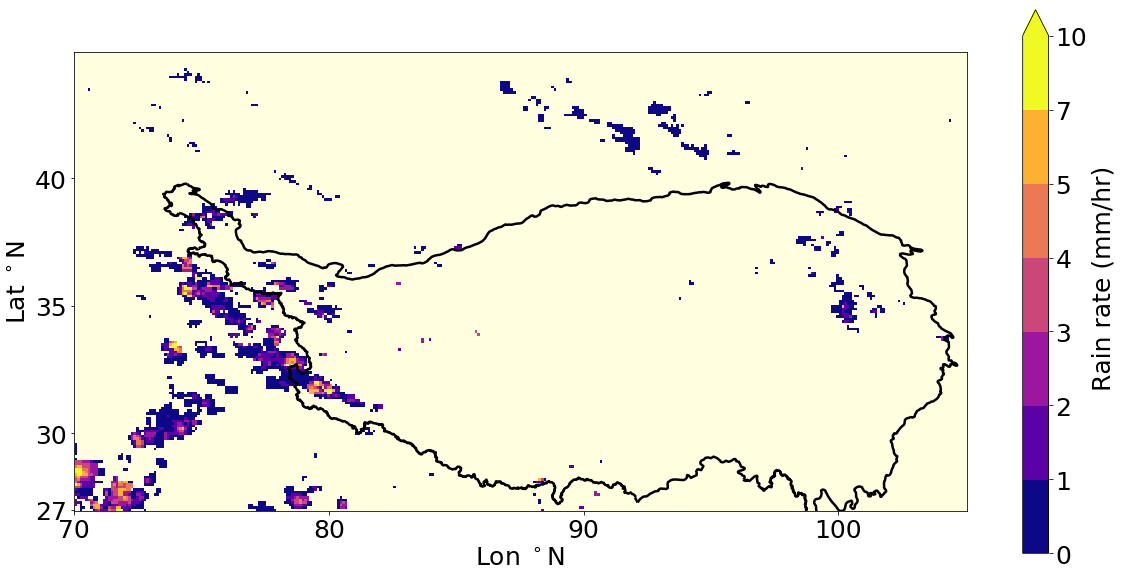

In [414]:
time_slot, prec,  lons, lats, date, time = read_in_netcdf(file, filename)

plt.figure(figsize=(20, 10))

cmap = plt.cm.get_cmap('plasma')
bounds= np.array([0, 1 , 2, 3, 4,  5, 7, 10])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)

m = Basemap(projection='cyl', llcrnrlat=26.95,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')
lon, lat =np.meshgrid(lons[:,0], lats[0,:])
xi,yi = m(lon,lat)
cs = m.pcolormesh(xi,yi, np.fliplr(prec.T), cmap=cmap, norm = norm, vmin= 0.01, vmax= 10 )
cmap.set_under(color='lightyellow')


xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$N')
plt.ylabel('Lat $^\circ$N')

# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


cbar = plt.colorbar(extend= 'max')
cbar.set_label(' Rain rate (mm/hr)')
cbar.set_ticks(bounds)
labels = ['0', '1', '2', '3','4', '5', '7', '10']
cbar.set_ticklabels(labels)

plt.rcParams.update({'font.size': 25})

plt.show()


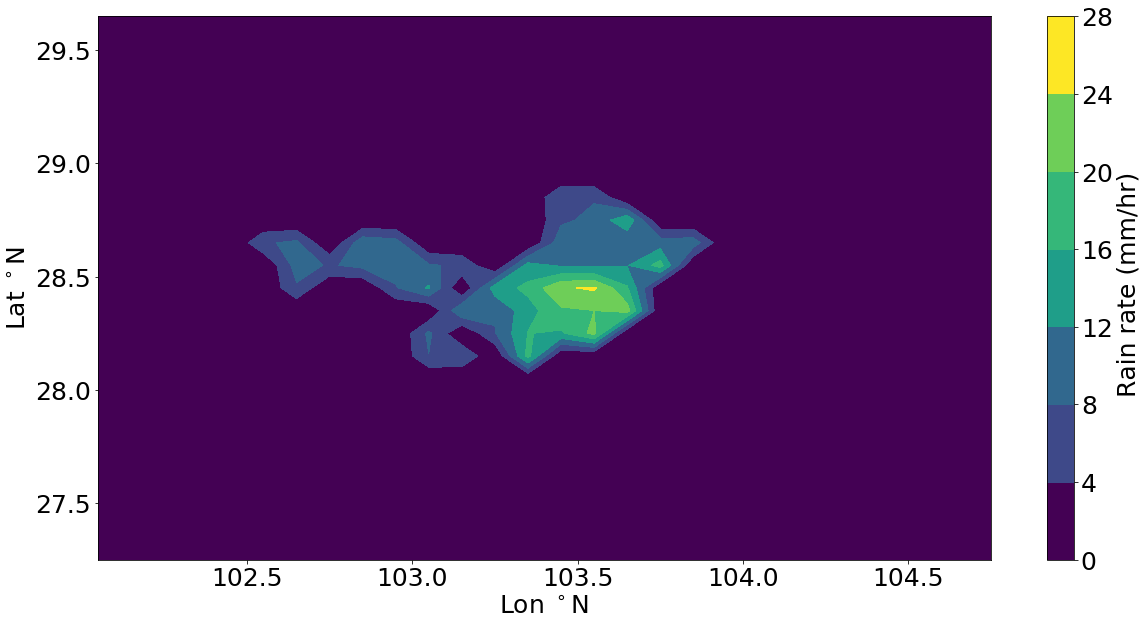

In [427]:
#val = mcs_labels[mcs_next == mcs[mcs == np.max(mcs)] ]   # get ID from MCS with strongest precipitation in this time slot 

loc= np.where(mcs_labels == val)

fig = plt.figure(figsize=(20, 10))

if np.min(loc[0] > 9):
    r1= np.min(loc[0])-10
else:
    r1= 0 

if np.min(loc[1] > 9):
    c1= np.min(loc[1]-10)
else:
    c1 = 0

r2= np.max(loc[0])+10
c2= np.max(loc[1])+10

cmap = plt.cm.get_cmap('viridis', lut= 10)

plt.xlabel('Lon $^\circ$N')
plt.ylabel('Lat $^\circ$N')


m = Basemap(projection='cyl', llcrnrlat=lats[0,c1],urcrnrlat=lats[0, c2-1], llcrnrlon= lons[r1,0], urcrnrlon=lons[r2-1,0],  resolution = 'c')
lon, lat =np.meshgrid(lons[r1:r2,0], lats[0,c1:c2])
xi,yi = m(lon,lat)
cs = plt.contourf(xi,yi, np.fliplr(mcs_next[r1:r2, c1:c2].T), cmap=cmap)
cmap.set_under(color='lightyellow')

cbar = plt.colorbar(extend= 'max')
cbar.set_label(' Rain rate (mm/hr)')
plt.rcParams.update({'font.size': 25})

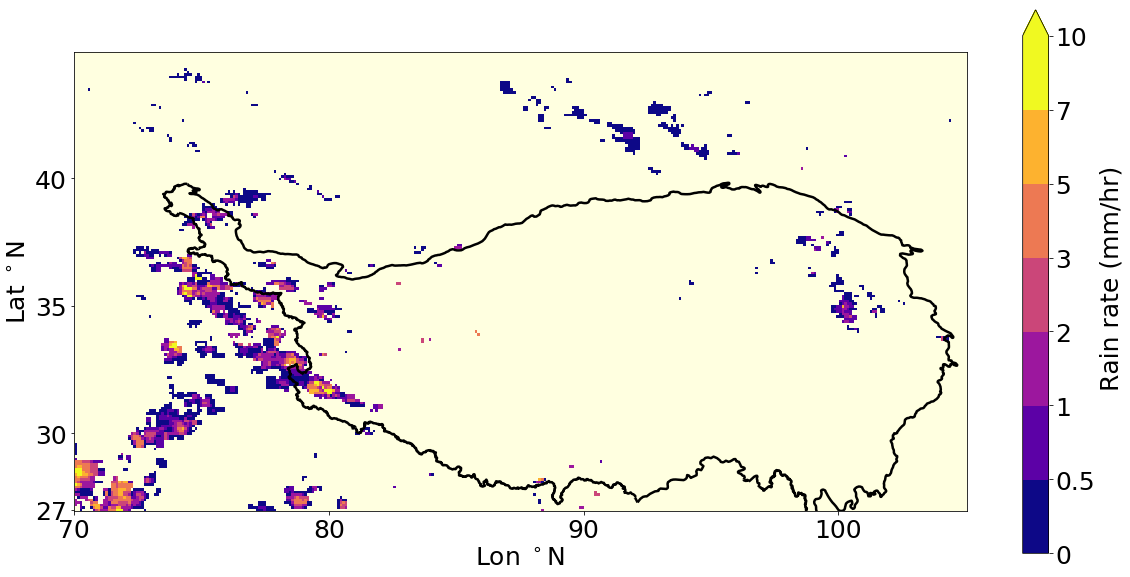

In [426]:
    plt.figure(figsize=(20, 10))

    cmap = plt.cm.get_cmap('plasma')
    bounds= np.array([0, 0.5, 1 , 2, 3, 5, 7, 10])
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors= 256)


    m = Basemap(projection='cyl', llcrnrlat=26.95,urcrnrlat=44.95, llcrnrlon=70.05, urcrnrlon=105.05,  resolution = 'c')
    lon, lat =np.meshgrid(lons[:,0], lats[0,:])
    xi,yi = m(lon,lat)
    cs = m.pcolormesh(xi,yi, np.fliplr(prec.T), cmap=cmap, norm = norm, vmin= 0.01, vmax = 10 )
    cmap.set_under(color='lightyellow')


    xlabels=[70, 80, 90, 100]
    ylabels= [ 27, 30, 35, 40]

    plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
    plt.yticks([27,30, 35, 40],ylabels, fontsize=25)
    plt.xlabel('Lon $^\circ$N')
    plt.ylabel('Lat $^\circ$N')

    # Plot TP boundary polyline from shapefile 
    shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
    TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)


    cbar = plt.colorbar(extend= 'max')
    cbar.set_label(' Rain rate (mm/hr)')
    cbar.set_ticks(bounds)
    labels = ['0', '0.5', '1', '2', '3', '5', '7', '10']
    cbar.set_ticklabels(labels)

    plt.rcParams.update({'font.size': 25})